# Mohammad Ali Mojtahed Soleimani

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, l1_lambda=0, l2_lambda=0, dropout_rate=0):
        super(SimpleCNN, self).__init__()
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Assuming input size of 224x224
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 102)  # Caltech-101 has 101 categories + background

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu3(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

    def l1_regularization_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, 1)
        return self.l1_lambda * l1_loss

    def l2_regularization_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)
        return self.l2_lambda * l2_loss

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    full_dataset = datasets.Caltech101(root='./data', download=True, transform=data_transform)
except RuntimeError as e:
    if "HTTP Error 503: Service Unavailable" in str(e):
        print("Error: Caltech-101 server might be unavailable. Try again later or use a different dataset.")
        exit()

Files already downloaded and verified


In [11]:
def create_subset_with_all_classes(full_dataset, samples_per_class):
    class_indices = {}  # Dictionary to store indices for each class
    for idx, (_, label) in enumerate(full_dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    subset_indices = []
    for label, indices in class_indices.items():
        # Ensure we don't sample more than available
        num_samples = min(samples_per_class, len(indices))
        sampled_indices = random.sample(indices, num_samples)
        subset_indices.extend(sampled_indices)

    return Subset(full_dataset, subset_indices)


subset_dataset = create_subset_with_all_classes(full_dataset, 35)

In [12]:
train_size = int(0.8 * len(subset_dataset))
val_size = int(0.1 * len(subset_dataset))
test_size = len(subset_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Add L1 and/or L2 regularization loss if applicable
            if model.l1_lambda > 0:
                loss += model.l1_regularization_loss()
            if model.l2_lambda > 0:
                loss += model.l2_regularization_loss()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Add L1 and/or L2 regularization loss if applicable
                if model.l1_lambda > 0:
                    loss += model.l1_regularization_loss()
                if model.l2_lambda > 0:
                    loss += model.l2_regularization_loss()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, test_loader

In [14]:
num_epochs = 10
results = {}
trained_models = {}

In [15]:
# 1. No Regularization
print("Training without regularization:")
model_no_reg = SimpleCNN()
train_losses, val_losses, train_accuracies, val_accuracies, test_loader_no_reg = train_and_evaluate(model_no_reg, train_loader, val_loader, test_loader, num_epochs)
results['No Regularization'] = (train_losses, val_losses, train_accuracies, val_accuracies)
trained_models['No Regularization'] = model_no_reg

Training without regularization:
Epoch [1/10], Train Loss: 4.9366, Train Acc: 1.24%, Val Loss: 4.6306, Val Acc: 0.85%
Epoch [2/10], Train Loss: 4.6257, Train Acc: 1.10%, Val Loss: 4.6307, Val Acc: 0.85%
Epoch [3/10], Train Loss: 4.6246, Train Acc: 1.06%, Val Loss: 4.6307, Val Acc: 0.85%
Epoch [4/10], Train Loss: 4.5994, Train Acc: 1.53%, Val Loss: 4.5458, Val Acc: 3.12%
Epoch [5/10], Train Loss: 4.3628, Train Acc: 6.53%, Val Loss: 4.3259, Val Acc: 8.52%
Epoch [6/10], Train Loss: 3.4561, Train Acc: 22.72%, Val Loss: 4.3803, Val Acc: 10.23%
Epoch [7/10], Train Loss: 2.0372, Train Acc: 49.84%, Val Loss: 5.4671, Val Acc: 10.51%
Epoch [8/10], Train Loss: 0.9404, Train Acc: 76.85%, Val Loss: 8.3534, Val Acc: 10.80%
Epoch [9/10], Train Loss: 0.4784, Train Acc: 88.00%, Val Loss: 8.8439, Val Acc: 10.51%
Epoch [10/10], Train Loss: 0.1998, Train Acc: 95.67%, Val Loss: 11.3476, Val Acc: 11.93%


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# 2. L1 Regularization
print("\nTraining with L1 Regularization:")
model_l1 = SimpleCNN(l1_lambda=0.001).to(device)
train_losses, val_losses, train_accuracies, val_accuracies, test_loader_l1 = train_and_evaluate(model_l1, train_loader, val_loader, test_loader, num_epochs)
results['L1 Regularization'] = (train_losses, val_losses, train_accuracies, val_accuracies)
trained_models['L1 Regularization'] = model_l1


Training with L1 Regularization:
Epoch [1/10], Train Loss: 9.5620, Train Acc: 1.03%, Val Loss: 6.7147, Val Acc: 1.42%
Epoch [2/10], Train Loss: 6.6630, Train Acc: 1.35%, Val Loss: 6.6735, Val Acc: 0.85%
Epoch [3/10], Train Loss: 6.6077, Train Acc: 1.06%, Val Loss: 6.5605, Val Acc: 1.42%
Epoch [4/10], Train Loss: 6.5339, Train Acc: 1.56%, Val Loss: 6.5475, Val Acc: 3.12%
Epoch [5/10], Train Loss: 6.7245, Train Acc: 2.24%, Val Loss: 6.6309, Val Acc: 2.84%
Epoch [6/10], Train Loss: 6.5944, Train Acc: 4.22%, Val Loss: 6.6251, Val Acc: 4.55%
Epoch [7/10], Train Loss: 6.4989, Train Acc: 5.96%, Val Loss: 6.5866, Val Acc: 7.10%
Epoch [8/10], Train Loss: 6.5939, Train Acc: 8.20%, Val Loss: 6.4879, Val Acc: 9.66%
Epoch [9/10], Train Loss: 6.4199, Train Acc: 10.08%, Val Loss: 6.4362, Val Acc: 9.38%
Epoch [10/10], Train Loss: 6.3247, Train Acc: 11.29%, Val Loss: 6.3089, Val Acc: 14.77%


In [18]:
# 3. L2 Regularization
print("\nTraining with L2 Regularization:")
model_l2 = SimpleCNN(l2_lambda=0.001)
train_losses, val_losses, train_accuracies, val_accuracies, test_loader_l2 = train_and_evaluate(model_l2, train_loader, val_loader, test_loader, num_epochs)
results['L2 Regularization'] = (train_losses, val_losses, train_accuracies, val_accuracies)
trained_models['L2 Regularization'] = model_l2


Training with L2 Regularization:
Epoch [1/10], Train Loss: 4.8772, Train Acc: 0.99%, Val Loss: 4.6590, Val Acc: 0.85%
Epoch [2/10], Train Loss: 4.6544, Train Acc: 0.96%, Val Loss: 4.6571, Val Acc: 0.85%
Epoch [3/10], Train Loss: 4.6506, Train Acc: 0.96%, Val Loss: 4.6550, Val Acc: 1.70%
Epoch [4/10], Train Loss: 4.5983, Train Acc: 2.02%, Val Loss: 4.5486, Val Acc: 4.26%
Epoch [5/10], Train Loss: 4.2230, Train Acc: 7.85%, Val Loss: 4.2934, Val Acc: 9.09%
Epoch [6/10], Train Loss: 3.0971, Train Acc: 29.43%, Val Loss: 4.3320, Val Acc: 15.91%
Epoch [7/10], Train Loss: 1.6348, Train Acc: 59.89%, Val Loss: 5.3989, Val Acc: 15.06%
Epoch [8/10], Train Loss: 0.6795, Train Acc: 82.46%, Val Loss: 6.8790, Val Acc: 13.64%
Epoch [9/10], Train Loss: 0.2585, Train Acc: 94.36%, Val Loss: 9.8008, Val Acc: 13.92%
Epoch [10/10], Train Loss: 0.1516, Train Acc: 97.83%, Val Loss: 10.5775, Val Acc: 14.20%


In [19]:
# 4. Dropout
print("\nTraining with Dropout:")
model_dropout = SimpleCNN(dropout_rate=0.5)
train_losses, val_losses, train_accuracies, val_accuracies, test_loader_dropout = train_and_evaluate(model_dropout, train_loader, val_loader, test_loader, num_epochs)
results['Dropout'] = (train_losses, val_losses, train_accuracies, val_accuracies)
trained_models['Dropout'] = model_dropout


Training with Dropout:
Epoch [1/10], Train Loss: 4.9125, Train Acc: 0.99%, Val Loss: 4.6251, Val Acc: 0.57%
Epoch [2/10], Train Loss: 4.5858, Train Acc: 2.17%, Val Loss: 4.5329, Val Acc: 3.69%
Epoch [3/10], Train Loss: 4.4606, Train Acc: 3.62%, Val Loss: 4.4386, Val Acc: 5.68%
Epoch [4/10], Train Loss: 4.2350, Train Acc: 7.42%, Val Loss: 4.2337, Val Acc: 8.24%
Epoch [5/10], Train Loss: 3.9299, Train Acc: 11.57%, Val Loss: 4.0909, Val Acc: 11.93%
Epoch [6/10], Train Loss: 3.6581, Train Acc: 14.77%, Val Loss: 3.9608, Val Acc: 12.50%
Epoch [7/10], Train Loss: 3.4556, Train Acc: 18.53%, Val Loss: 3.8959, Val Acc: 15.91%
Epoch [8/10], Train Loss: 3.1722, Train Acc: 22.83%, Val Loss: 3.8795, Val Acc: 16.48%
Epoch [9/10], Train Loss: 3.0091, Train Acc: 26.52%, Val Loss: 3.8996, Val Acc: 15.91%
Epoch [10/10], Train Loss: 2.8043, Train Acc: 29.82%, Val Loss: 3.8538, Val Acc: 17.33%



Analyzing misclassifications for No Regularization:


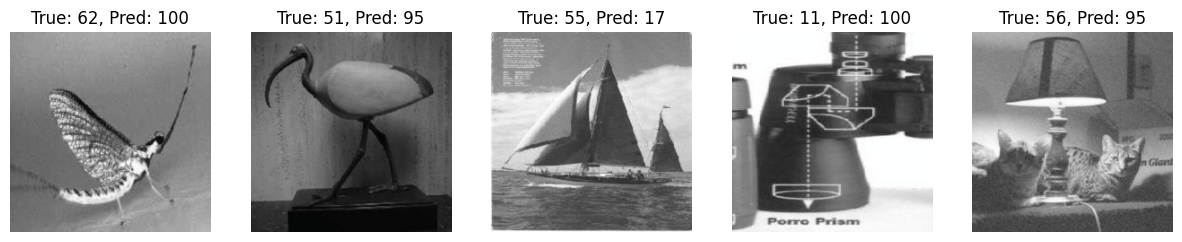


Analyzing misclassifications for L1 Regularization:


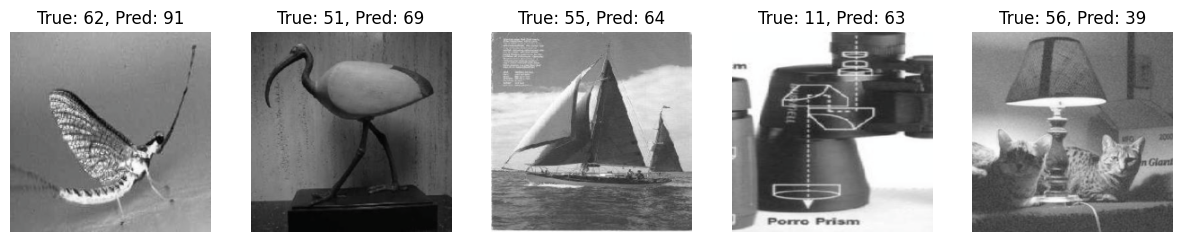


Analyzing misclassifications for L2 Regularization:


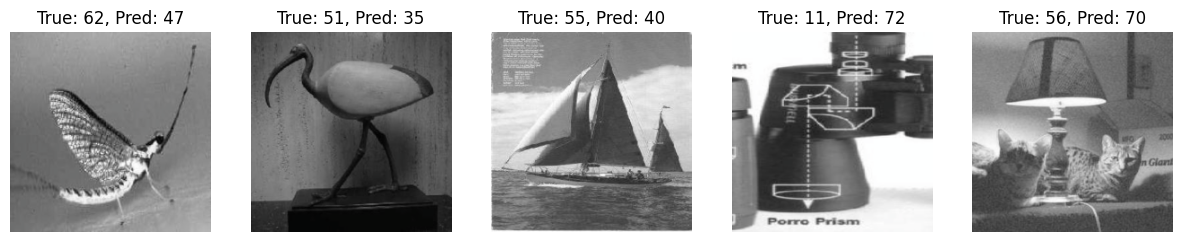


Analyzing misclassifications for Dropout:


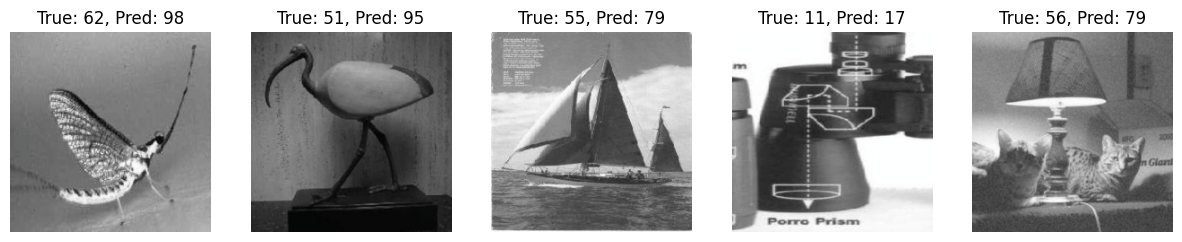

In [20]:
# --- Analyze Misclassifications ---
def analyze_misclassifications(model, test_loader, num_images=5):
    model.eval()
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                if predicted[i] != labels[i]:
                    misclassified_images.append(images[i])
                    true_labels.append(labels[i])
                    predicted_labels.append(predicted[i])

                if len(misclassified_images) >= num_images:
                    break
            if len(misclassified_images) >= num_images:
                break

    # Display misclassified images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        # Unnormalize the image for display
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        axes[i].axis('off')
    plt.show()

    return misclassified_images, true_labels, predicted_labels

# Analyze misclassifications for each model
for name, model in trained_models.items():
    print(f"\nAnalyzing misclassifications for {name}:")
    misclassified_images, true_labels, predicted_labels = analyze_misclassifications(model, test_loader, num_images=5)

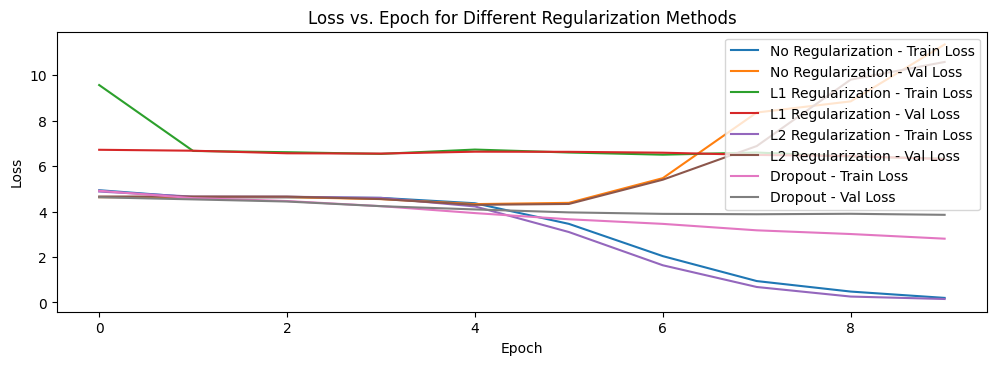

In [21]:
plt.figure(figsize=(12, 8))

# Plot Losses
plt.subplot(2, 1, 1)
for name, (train_losses, val_losses, _, _) in results.items():
    plt.plot(train_losses, label=f'{name} - Train Loss')
    plt.plot(val_losses, label=f'{name} - Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Different Regularization Methods')
plt.legend()

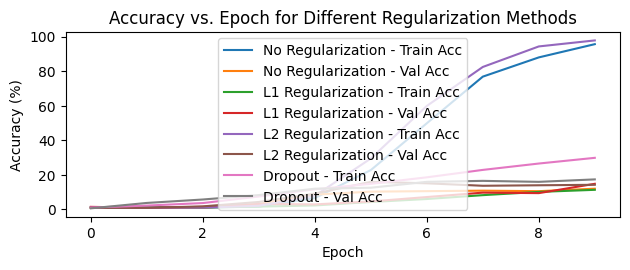

In [22]:
# Plot Accuracies
plt.subplot(2, 1, 2)
for name, (_, _, train_accuracies, val_accuracies) in results.items():
    plt.plot(train_accuracies, label=f'{name} - Train Acc')
    plt.plot(val_accuracies, label=f'{name} - Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch for Different Regularization Methods')
plt.legend()

plt.tight_layout()
plt.show()